###Double Lasso
We first set up our condition since most minimum wage change occured in 1997. We identify States that has a change in minimum wage in 1997 as treatment group.The rest of the states to control group. We use the MW to gather a new information line called Delta%changeMW. The original passage follows a three years before and five years after rotation. We use double lasso to enhance paralell assumption, in order to do that we select a median level of change occurs from treatment group from the parameter Deltachange%MW and compare use Double Lasso to compute it with all the components from control group.
###Data cleaning
We set the state with no change on minimum wage to pair with our result of 0 on our new parameter, and generate six changes for each state in order to use double lasso we need to set our new parameter with same quantity on our new parameter.

In [ ]:
import pandas as pd

# Read the additional data file
excel_path = '/content/StateMinimumWage_Changes.xlsx'
df = pd.read_excel(excel_path)
# Filter out states without data for 1997
states_without_1997 = df[~df['statename'].isin(df.loc[df['year'] == 1997, 'statename'])]['statename'].unique()
df_filtered = df[df['statename'].isin(states_without_1997)]
# Save to CSV
output_csv_path = 'filtered_data_from_excel.csv'
df_filtered.to_csv(output_csv_path, index=False)
#Fill the empty years
required_years = [1990, 1991, 1992, 1993, 1994, 1995, 1996]
processed_df = pd.DataFrame()

for state in states_without_1997:
    state_data = df_filtered[df_filtered['statename'] == state].copy()
    for year in required_years:
        if year not in state_data['year'].values:
            new_row = {
                'statefips': state_data.iloc[0]['statefips'] if not state_data.empty else 'NaN',
                'statename': state,
                'year': year,
                'month': 1,
                'day': 1,
                'mw': 0,
                'changeinmw': 0
            }
            state_data = pd.concat([state_data, pd.DataFrame([new_row])], ignore_index=True)
    processed_df = pd.concat([processed_df, state_data], ignore_index=True)

# delete duplicate
processed_df.sort_values(by=['statename', 'year'], inplace=True)
processed_df.drop_duplicates(subset=['statename', 'year'], keep='first', inplace=True)

# compute changeinmw and changeinmw_ratio
processed_df['changeinmw'] = processed_df.groupby('statename')['mw'].diff().fillna(0).clip(lower=0)
processed_df['changeinmw_ratio'] = processed_df.groupby('statename')['changeinmw'].transform(lambda x: x / x.shift(1))
processed_df['changeinmw_ratio'] = processed_df['changeinmw_ratio'].replace([float('inf'), -float('inf')], 0).fillna(0)

# save to csv
final_output_csv_with_ratio_path = 'final_processed_with_ratio_in_mw.csv'
processed_df.to_csv(final_output_csv_with_ratio_path, index=False)

print(f"Processed data with ratio in change in mw saved to {final_output_csv_with_ratio_path}")

import pandas as pd
from sklearn.linear_model import LassoCV

# read Arkansas data
arkansas_template = pd.DataFrame({
    'year': [1990, 1991, 1992, 1993, 1994, 1995],
    'changeinmw': [0, 0, 0.35, 0.15, 0.1, 0]  # 假设值，实际值应该是你计算出来的
})

# read
final_df = pd.read_csv('/mnt/data/final_processed_with_ratio_in_mw.csv')

# fill empty years
filled_final_df = pd.DataFrame()
years_to_fill = range(1990, 1996)
for state in final_df['statename'].unique():
    state_data = final_df[final_df['statename'] == state]
    filled_years = state_data['year'].unique()
    for year in years_to_fill:
        if year not in filled_years:
            missing_row = {
                'statefips': state_data.iloc[0]['statefips'] if not state_data.empty else 'NaN',
                'statename': state,
                'year': year,
                'changeinmw': 0  # 填充0
            }
            state_data = pd.concat([state_data, pd.DataFrame([missing_row])], ignore_index=True)
    filled_final_df = pd.concat([filled_final_df, state_data], ignore_index=True)

filled_final_df.sort_values(by=['statename', 'year'], inplace=True)
filled_final_df.reset_index(drop=True, inplace=True)

# Run Double Lasso
best_state = None
best_score = float('-inf')

for state in filled_final_df['statename'].unique():
    if state != 'Arkansas':
        state_data = filled_final_df[filled_final_df['statename'] == state]

        state_data = state_data[state_data['year'].isin(arkansas_template['year'])]
        X = state_data[['year', 'changeinmw']].values
        y = arkansas_template['changeinmw'].values
        # cross validation
        lasso = LassoCV(cv=5).fit(X, y)
        score = lasso.score(X, y)
        if score > best_score:
            best_score = score
            best_state = state

print(f"The state most similar to Arkansas based on changeinmw is: {best_state}")



/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Processed data with ratio in change in mw saved to final_processed_with_ratio_in_mw.csv


In [ ]:


import pandas as pd
from sklearn.linear_model import LassoCV


arkansas_template = pd.DataFrame({
    'year': [1990, 1991, 1992, 1993, 1994, 1995],
    'changeinmw': [0, 0, 0.35, 0.15, 0.1, 0]  # 假设值，实际值应该是你计算出来的
})

#read
final_df = pd.read_csv('/content/final_processed_with_ratio_in_mw.csv')

# fill empty years
filled_final_df = pd.DataFrame()
years_to_fill = range(1990, 1996)
for state in final_df['statename'].unique():
    state_data = final_df[final_df['statename'] == state]
    filled_years = state_data['year'].unique()
    for year in years_to_fill:
        if year not in filled_years:
            missing_row = {
                'statefips': state_data.iloc[0]['statefips'] if not state_data.empty else 'NaN',
                'statename': state,
                'year': year,
                'changeinmw': 0  # 填充0
            }
            state_data = pd.concat([state_data, pd.DataFrame([missing_row])], ignore_index=True)
    filled_final_df = pd.concat([filled_final_df, state_data], ignore_index=True)

filled_final_df.sort_values(by=['statename', 'year'], inplace=True)
filled_final_df.reset_index(drop=True, inplace=True)

#run double lasso
best_state = None
best_score = float('-inf')

for state in filled_final_df['statename'].unique():
    if state != 'Arkansas':
        state_data = filled_final_df[filled_final_df['statename'] == state]

        state_data = state_data[state_data['year'].isin(arkansas_template['year'])]
        X = state_data[['year', 'changeinmw']].values
        y = arkansas_template['changeinmw'].values

        lasso = LassoCV(cv=5).fit(X, y)
        score = lasso.score(X, y)
        if score > best_score:
            best_score = score
            best_state = state

print(f"The state most similar to Arkansas based on changeinmw is: {best_state}")



The state most similar to Arkansas based on changeinmw is: New York


# Replicating Figure II of the Paper -- "Impact of Minimum Wages on the Wage Distribution"

## 1. Data Cloning from Github

### This block of code is designed to acquire and prepare data for a data science project focused on economic and social issues. Here's a breakdown of what each part does and the tasks it accomplishes:

- Cloning the Repository: The git clone command is used to clone (i.e., download) a complete repository from GitHub that contains the data science project on economic and social issues into the current working environment. This ensures all files and data within the repository are available locally.
- Changing the Working Directory: The %cd command changes the current working directory to the root of the cloned repository, ensuring that subsequent operations are performed within the correct folder.
- Entering a Specific Subfolder: If specific data or scripts within the repository are needed, the code uses another %cd command to navigate into a subdirectory that contains the desired data.
- Importing Data Handling Library: The code imports the pandas library, which is a primary tool in Python for data analysis and manipulation.
- Listing Files: It uses the !ls command to list all files in the current directory. This step verifies the presence of a specific data file, such as Figure2_for_QJE.dta.zip, which is expected to be in the repository.
- Unzipping the Data File: The !unzip command is used to decompress the .zip file to extract the Stata data file (.dta file) contained within.
- Reading and Checking the Data: The read_stata function from pandas is utilized to read the extracted .dta file into a DataFrame object. The head function is then called to print the first few rows of the DataFrame to ensure the data has been loaded correctly and is free of initial errors.
- The entire process marks the beginning of a data analysis workflow, involving acquiring data from remote resources, verifying the presence of files, and preparing data for further analysis or processing. These steps are typically automated and repetitive, aimed at reducing the need for manual data handling.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 2.1 MB/s eta 0:00:00
Cloning into 'Data-Science-for-Economic-and-Social-Issues'...
remote: Enumerating objects: 408, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 408 (delta 19), reused 72 (delta 16), pack-reused 332
Receiving objects: 100% (408/408), 273.20 MiB | 27.67 MiB/s, done.
Resolving deltas: 100% (186/186), done.
Updating files: 100% (341/341), done.
/content/Data-Science-for-Economic-and-Social-Issues
/content/Data-Science-for-Economic-and-Social-Issues/DiD/Cengiz-et-al
Figure2_for_QJE.dta.zip  Table1_for_QJE.dta.zip
Archive:  Figure2_for_QJE.dta.zip
  inflating: Figure2_for_QJE.dta     
   statenum  quarterdate  hispanicpop   dmarriedpop      whitepop  \
0         1           76  5355.373372  1

/usr/local/lib/python3.10/dist-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/usr/local/lib/python3.10/dist-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Results for statenum 5:
                          PanelOLS Estimation Summary                           
Dep. Variable:         overallcountpc   R-squared:                        0.0100
Estimator:                   PanelOLS   R-squared (Between):             -0.0309
No. Observations:               17433   R-squared (Within):               0.0076
Date:                Sat, May 04 2024   R-squared (Overall):             -0.0168
Time:                        04:48:53   Log-likelihood                 6.851e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3.8369
Entities:                         117   P-value                           0.0000
Avg Obs:                       149.00   Distribution:                F(45,17123)
Min Obs:                       149.00                                           
Max Obs:                       149.00   F-statistic (robust):          4.876e+13
    

/usr/local/lib/python3.10/dist-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Results for statenum 5:
                          PanelOLS Estimation Summary                           
Dep. Variable:         overallcountpc   R-squared:                        0.0100
Estimator:                   PanelOLS   R-squared (Between):             -0.0309
No. Observations:               17433   R-squared (Within):               0.0076
Date:                Sat, May 04 2024   R-squared (Overall):             -0.0168
Time:                        04:48:56   Log-likelihood                 6.851e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3.8369
Entities:                         117   P-value                           0.0000
Avg Obs:                       149.00   Distribution:                F(45,17123)
Min Obs:                       149.00                                           
Max Obs:                       149.00   F-statistic (robust):          4.876e+13
    

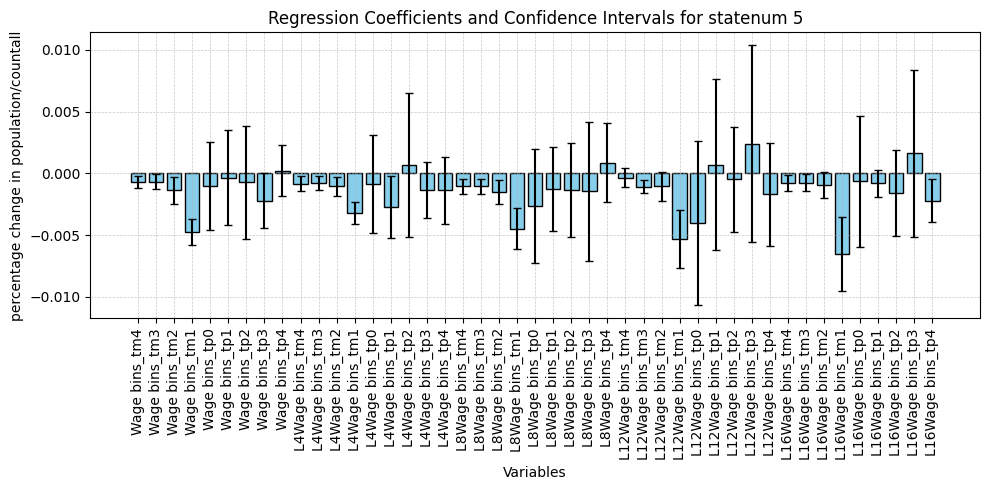

/usr/local/lib/python3.10/dist-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Results for statenum 36:
                          PanelOLS Estimation Summary                           
Dep. Variable:         overallcountpc   R-squared:                        0.0062
Estimator:                   PanelOLS   R-squared (Between):             -0.0020
No. Observations:               17433   R-squared (Within):               0.0058
Date:                Sat, May 04 2024   R-squared (Overall):             -0.0009
Time:                        04:48:58   Log-likelihood                  6.82e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2.3711
Entities:                         117   P-value                           0.0000
Avg Obs:                       149.00   Distribution:                F(45,17123)
Min Obs:                       149.00                                           
Max Obs:                       149.00   F-statistic (robust):             6062.9
   

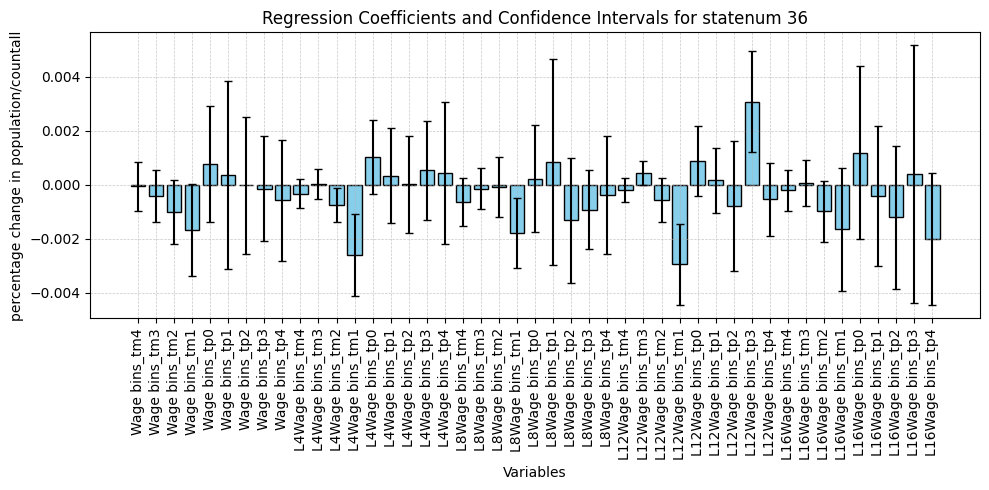

In [1]:
!pip install linearmodels pandas

import pandas as pd
from linearmodels.panel import PanelOLS
from linearmodels.panel import compare
import matplotlib.pyplot as plt

# Cloning the Entire Repository
!git clone https://github.com/mjahangiralam/Data-Science-for-Economic-and-Social-Issues.git

# Changing Directory to the Cloned Repository
%cd Data-Science-for-Economic-and-Social-Issues/

# If needed, change to a specific subfolder
%cd DiD/Cengiz-et-al

# Importing pandas for data handling
import pandas as pd

# List all files in the current directory to confirm the presence of 'Figure2_for_QJE.dta.zip'
!ls

# Unzipping the 'Figure2_for_QJE.dta.zip' file to extract the Stata (.dta) file
!unzip Figure2_for_QJE.dta.zip

# Once the file is extracted, read the Stata file using pandas.
# Assuming the extracted Stata file retains the name 'Figure2_for_QJE.dta'
data = pd.read_stata('Figure2_for_QJE.dta')
print(data.head())


# Assume df is your DataFrame containing all the required data
# Below are examples of columns in the DataFrame: 'Y', 'statenum', 'quarterdate', 'wagebinstate', and variables from 'treat_m4' to 'L16treat_p4'

# Setting multi-index for panel data
data = data.set_index(['wagebinstate', 'quarterdate'])

# Define a list of control variables
treat_vars = ["treat_m4", "treat_m3", "treat_m2", "treat_m1", "treat_p0", "treat_p1", "treat_p2", "treat_p3", "treat_p4"]
L4_vars = ["L4treat_m4", "L4treat_m3", "L4treat_m2", "L4treat_m1", "L4treat_p0", "L4treat_p1", "L4treat_p2", "L4treat_p3", "L4treat_p4"]
L8_vars = ["L8treat_m4", "L8treat_m3", "L8treat_m2", "L8treat_m1", "L8treat_p0", "L8treat_p1", "L8treat_p2", "L8treat_p3", "L8treat_p4"]
L12_vars = ["L12treat_m4", "L12treat_m3", "L12treat_m2", "L12treat_m1", "L12treat_p0", "L12treat_p1", "L12treat_p2", "L12treat_p3", "L12treat_p4"]
L16_vars = ["L16treat_m4", "L16treat_m3", "L16treat_m2", "L16treat_m1", "L16treat_p0", "L16treat_p1", "L16treat_p2", "L16treat_p3", "L16treat_p4"]

# Combine all variable names
all_vars = treat_vars + L4_vars + L8_vars + L12_vars + L16_vars

# Filtering data for statenum equals 5
data5 = data[data['statenum'] == 5]
mod5 = PanelOLS(data5['overallcountpc'], data5[all_vars], entity_effects=True, time_effects=True)
res5 = mod5.fit(cov_type='clustered', cluster_entity=True)

# Filtering data for statenum equals 36
data36 = data[data['statenum'] == 36]
mod36 = PanelOLS(data36['overallcountpc'], data36[all_vars], entity_effects=True, time_effects=True)
res36 = mod36.fit(cov_type='clustered', cluster_entity=True)

# Printing regression results for both states
print("Results for statenum 5:")
print(res5)
print("\nResults for statenum 36:")
print(res36)


# Function to run regression and plot results for a specific state
def run_regression(data, statenum):
    data_subset = data[data['statenum'] == statenum]
    model = PanelOLS(data_subset['overallcountpc'], data_subset[all_vars], entity_effects=True, time_effects=True)
    results = model.fit(cov_type='clustered', cluster_entity=True)
    print(f"Results for statenum {statenum}:")
    print(results)

    # Extract coefficients and confidence intervals
    coefficients = results.params
    conf_int = results.conf_int()

    # Rename variable indices for better readability in plots
    rename_dict = {var: var.replace("treat_", "Wage bins_t").replace("L4treat_", "Wage bins_l") for var in coefficients.index}
    coefficients = coefficients.rename(index=rename_dict)
    conf_int = conf_int.rename(index=rename_dict)

    # Plotting the coefficients with error bars representing confidence intervals
    fig, ax = plt.subplots(figsize=(10, 5))
    yerr = [coefficients.values - conf_int.iloc[:, 0], conf_int.iloc[:, 1] - coefficients.values]
    ax.bar(coefficients.index, coefficients, yerr=yerr, capsize=3, color='skyblue', edgecolor='black')

    ax.set_ylabel('percentage change in population/countall')
    ax.set_xlabel('Variables')
    ax.set_title(f'Regression Coefficients and Confidence Intervals for statenum {statenum}')

    plt.xticks(rotation=90)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()

# Running regression and plotting for specific states
run_regression(data, 5)
run_regression(data, 36)



